# 2D ring resonator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FRingResonator.ipynb).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 2 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform the simulation in just a few minutes.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

In [21]:
# define pulse parameters
lambda0 = 0.5
freq0 = td.C_0 /lambda0
fwidth =  freq0 / 6
min_steps_per_wvl = 30
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#mediums)

In [22]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#structures)


In [23]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

Compute and visualize the waveguide modes.

In [24]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    run_time=1e-12,
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0])
mode_data = mode_solver.solve()

[17:16:17] WARNING  No sources in simulation.                               ]8;id=363128;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:388

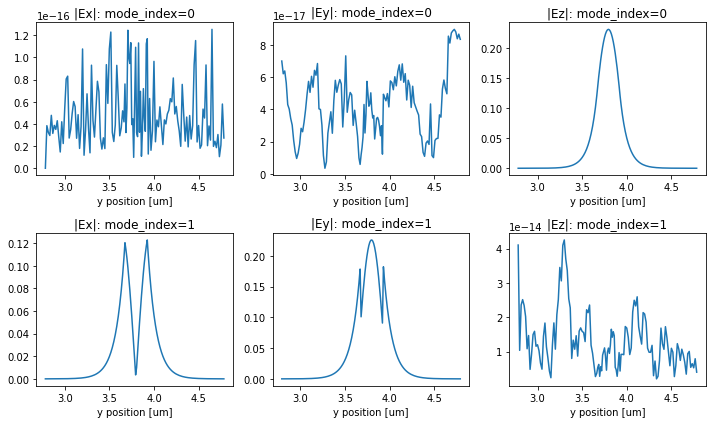

In [25]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
abs(mode_data.fields.Ex.sel(mode_index=0).abs).plot(ax=ax1)
abs(mode_data.fields.Ey.sel(mode_index=0).abs).plot(ax=ax2)
abs(mode_data.fields.Ez.sel(mode_index=0).abs).plot(ax=ax3)
abs(mode_data.fields.Ex.sel(mode_index=1).abs).plot(ax=ax4)
abs(mode_data.fields.Ey.sel(mode_index=1).abs).plot(ax=ax5)
abs(mode_data.fields.Ez.sel(mode_index=1).abs).plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [26]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+'
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [27]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(0.4, 0.6, 1001)
freqs_measure = td.C_0 / lambdas_measure

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor.center = [+wg_insert_x, wg_center_y, 0]

Define simulation. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#simulation)
To make the simulation 2D, we can just set the simulation size in one of the dimensions to be 0. However, note that we still have to define a grid size in that direction.

In [28]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time_norm,
    pml_layers=[td.PML(), td.PML(), None])

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    pml_layers=[td.PML(), td.PML(), None])

----
Visualize structure, source, and modes. [(docs)](https://docs.simulation.cloud/en/latest/howdoi.html#plot-data)

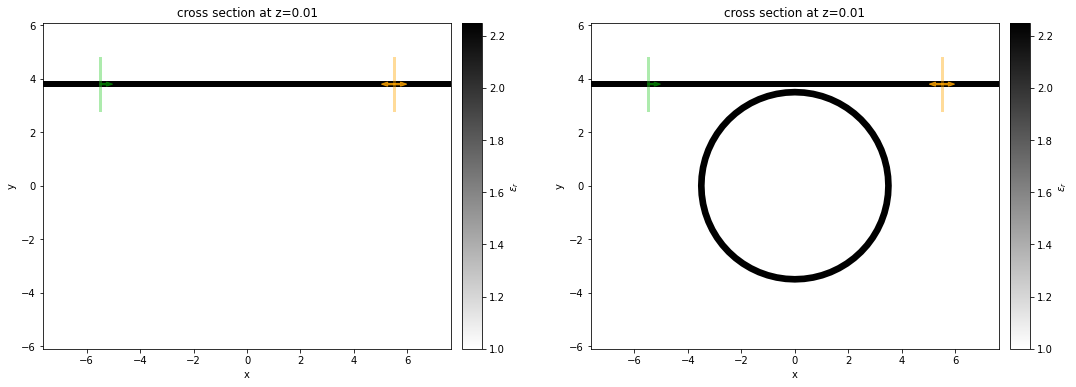

In [29]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://docs.simulation.cloud/en/latest/api.html#submitting-simulations)

In [30]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

[17:16:26] INFO     Uploaded task 'normalization' with task_id                  ]8;id=65730;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:120
                    'e939a4e2-a2b7-4e6a-9e23-456912a850fa'.

[17:16:28] INFO     Maximum flex unit cost: 0.20                                ]8;id=633899;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:141

Output()

[17:16:37] INFO     status = preprocess                                         ]8;id=297023;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:263

[17:17:05] INFO     starting up solver                                          ]8;id=118137;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:267

[17:17:37] INFO     running solver                                              ]8;id=78167;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:272

Output()

[17:17:41] INFO     early shutoff detected, exiting.                            ]8;id=98159;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:282

Output()

[17:17:45] INFO     status = postprocess                                        ]8;id=124653;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:291

[17:18:26] INFO     status = success                                            ]8;id=827910;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:291

[17:18:30] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=830426;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:522
                    "data/simulation_data0.hdf5"

Output()

[17:18:38] INFO     loading SimulationData from data/simulation_data0.hdf5      ]8;id=599869;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:357

[17:18:41] INFO     Uploaded task 'with_ring' with task_id                      ]8;id=40889;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:120
                    '26037984-8111-44d6-b853-e21d54f00cff'.

[17:18:42] INFO     Maximum flex unit cost: 0.20                                ]8;id=999347;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:141

Output()

[17:18:51] INFO     status = preprocess                                         ]8;id=182092;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:263

[17:19:11] INFO     starting up solver                                          ]8;id=513554;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:267

[17:20:13] INFO     running solver                                              ]8;id=579926;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:272

Output()

[17:20:17] INFO     early shutoff detected, exiting.                            ]8;id=786717;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:282

Output()

[17:20:21] INFO     status = postprocess                                        ]8;id=265535;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:291

[17:20:54] INFO     status = success                                            ]8;id=498237;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:291

[17:20:58] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=629362;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:522
                    "data/simulation_data.hdf5"

Output()

[17:21:07] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=932291;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:357

In [31]:
print(sim_data0.log)

Simulation domain Nx, Ny, Nz: [1375, 741, 1]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.0189e+06.
Using subpixel averaging: True
Number of time steps: 4.7330e+03
Automatic shutoff factor: 1.00e-05
Time step (s): 2.1135e-17
Compute source modes time (s):     0.2530
Compute monitor modes time (s):    20.3424


Starting solver...
- Time step    189 / time 3.99e-15s (  4 % done), field decay: 1.00e+00
- Time step    377 / time 7.97e-15s (  7 % done), field decay: 1.00e+00
- Time step    378 / time 7.99e-15s (  8 % done), field decay: 1.00e+00
- Time step    567 / time 1.20e-14s ( 12 % done), field decay: 1.00e+00
- Time step    757 / time 1.60e-14s ( 16 % done), field decay: 9.96e-01
- Time step    946 / time 2.00e-14s ( 20 % done), field decay: 9.96e-01
- Time step   1135 / time 2.40e-14s ( 24 % done), field decay: 9.94e-01
- Time step   1325 / time 2.80e-14s ( 28 % done), field decay: 9.94e-01
- Time step   1514 / time 3.20e-14s ( 32 % done), field decay: 9.93e-

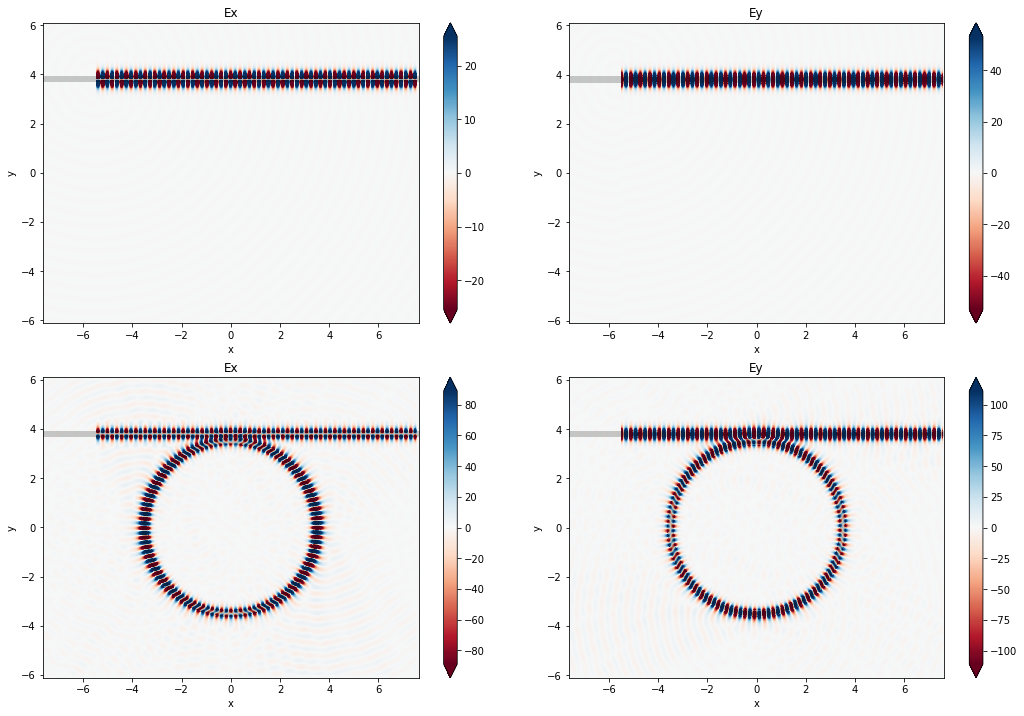

In [32]:
# visualize normalization run
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(15, 10))

ax1 = sim_data0.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax1)
ax2 = sim_data0.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax2)
ax1.set_title('Ex')
ax2.set_title('Ey')

ax3 = sim_data.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax3)
ax4 = sim_data.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax4)
ax3.set_title('Ex')
ax4.set_title('Ey')

plt.show()

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [33]:
sim_data['mode']

ModeData(type='ModeData', data_dict={'amps': ModeAmpsData(type='ModeAmpsData', values=array([[[ 6.52669311e-10+2.08548105e-10j,
          6.67195659e-01-7.32931403e-01j],
        [ 3.52018366e-10-4.16350023e-11j,
          5.30811700e-01-8.35480367e-01j],
        [ 2.07236596e-10-7.69807309e-11j,
          3.88870658e-01-9.08822288e-01j],
        ...,
        [-9.68409578e-11-8.70295666e-12j,
         -8.79980629e-01-4.26720153e-01j],
        [-9.34671634e-11+1.86365170e-11j,
         -9.25099767e-01-3.18530531e-01j],
        [-8.65084105e-11+4.37132465e-11j,
         -9.56220788e-01-2.08259935e-01j]],

       [[-4.42154526e-13-2.39344967e-13j,
         -3.56178171e-06+1.68637738e-05j],
        [-5.38856260e-13-1.72663459e-13j,
         -1.21016745e-05-5.22278792e-05j],
        [-5.69358407e-13-8.36534634e-14j,
         -1.01814776e-06-1.68965356e-05j],
        ...,
        [-2.02515877e-14+2.26700198e-14j,
          2.31438415e-05-5.04585636e-05j],
        [-1.27981062e-14+2.94142319e-14j,
          4.54419995e-06-4.27638477e-05j],
        [-1.24380896e-14+2.43971216e-14j,
         -7.23866968e-06-4.09869246e-05j]]]), data_attrs={'units': 'sqrt(W)', 'long_name': 'mode amplitudes'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]), direction=['+', '-']), 'n_complex': ModeIndexData(type='ModeIndexData', values=array([[1.39832878-8.08547459e-18j, 1.3546186 +5.38415794e-18j],
       [1.39825972+8.09087845e-18j, 1.35450388+3.17332152e-18j],
       [1.39819065-5.04168049e-18j, 1.35438915-5.89299999e-18j],
       ...,
       [1.33126784-4.66616783e-19j, 1.24254995+1.94245344e-14j],
       [1.33120393-3.08786544e-18j, 1.24244685+1.97790231e-14j],
       [1.33114003-4.32812885e-18j, 1.24234379+2.01588139e-14j]]), data_attrs={'units': '', 'long_name': 'effective index'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]))})

As we see, the mode amplitude data is complex-valued with three 3 dimensions:

- index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).

- direction of the propagation (for decomposition).

- frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency and divide the results with a ring by the normalization.

In [34]:
mode_data = sim_data['mode'].amps.sel(mode_index=1, direction='+')
mode_data0 = sim_data0['mode'].amps.sel(mode_index=1, direction='+')
transmission_amps = mode_data / mode_data0

Now let's plot the data.

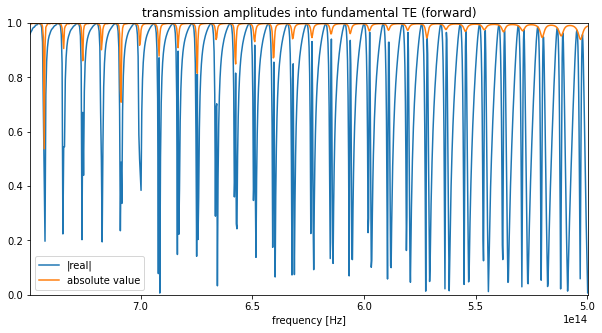

In [35]:
f, ax = plt.subplots(figsize=(10, 5))
abs(transmission_amps.real).plot.line(x='f', ax=ax, label='|real|')
# abs(transmission_amps.imag).plot.line(x='f', ax=ax, label='|imag|')
abs(transmission_amps).plot.line(x='f', ax=ax, label='absolute value')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
ax.set_ylim(0, 1)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()